# Module 2: Feature Spaces en Collaborative Filtering

## Doel

Services als Bol.com, Amazon, YouTube, Netflix willen allemaal voorspellen welke producten (boeken, films, etc.) jij interessant vindt. In deze opdracht ga je zelf een systeem maken dat zulke voorspellingen kan doen. 

Vaak gebeurt dit door goed te kijken naar je gedrag op een website. Gebruikers bekijken producten, kopen producten en geven waarderingen (ratings). Deze informatie geeft een beeld van de producten die je leuk vindt. Vervolgens is de kunst om producten te vinden die daar op lijken. De kans is groot dat je die dan ook wel leuk vindt. 

Een manier om te achterhalen of bijvoorbeeld twee films op elkaar lijken is door de inhoud te vergelijken. (Bijvoorbeeld: Gaan ze bijvoorbeeld over hetzelfde onderwerp? Zijn ze gemaakt door dezelfde regiseur?) Film aanbevelen aan de hand van dit soort vergelijkingen heet _content based filtering_. Daar gaan we in een latere opdracht naar kijken.

De opdracht deze week is gericht op _collaborative filtering_. Hierbij is het idee dat het collectieve gedrag van de gebruikers informatie geeft over de producten.

In collaborative filtering kan je weer twee strategieën onderscheiden: _user based filtering_ en _item based filtering_. Met user based filtering probeer je er achter te komen in welke mate gebruikers in gedrag op elkaar lijken en daarop gebaseerd een film aan te raden. Met item based filtering probeer je juist vast te stellen in welke mate twee films op elkaar lijken.

Welke aanpak is het best? Content based filtering? User based collaborative filtering? Item based collaborative filtering? Daar valt geen eenduidig antwoord op te geven. Dat blijkt enorm af te hangen van de specifieke toepassing.

Bij elke aanpak zijn boevendien een hoop subtiele keuzes te maken zijn die de prestaties kunnen beïnvloeden. Je kan bijvoorbeeld verschillende keuzes maken in hoe je meet of twee producten (of gebruikers) op elkaar lijken. Hieronder kom je twee veelgebruikte maten daarvoor tegen: _euclidean similarity_ en _cosine similarity_. En in de praktijk zijn het er nog veel meer dan dat.  

## Opbouw

In deze module ga je _user based filtering_ en _item based filtering_ uitwerken. In de volgende module ga je de prestaties van deze aanpakken met elkaar vergelijken.

## Studiemateriaal

- [Collaborative filtering, Harvard CS50](https://www.youtube.com/watch?v=Eeg1DEeWUjA)
- [Recommender systems handbook, Springerlink](https://link.springer.com/book/10.1007%2F978-0-387-85820-3) Hoofdstuk 1. Gratis te downloaden vanaf het UvA netwerk.

Voor het maken van een collaborative filtering systeem maken we gebruik van de movieLens dataset die je ook in de vorige opdracht hebt gezien. We willen deze data gebruiken om gebruikers een film aan te raden die ze nog niet hebben gezien. Dit willen we doen gebaseerd op de ratings die de gebruiker voor _andere_ films heeft gegeven. 

We willen dus voor een gebruiker weten hoe goed hij of zij een bepaalde film _waarschijnlijk_ gaat vinden. Als we het probleem herformuleren in termen van ratings: **Gegeven een gebruiker die een bepaalde film nog niet heeft gezien, _voorspel de rating_ die de gebruiker aan de film zou gegeven na het zien van de film.**

## Aan de slag

We beginnen met het laden van de libraries die we nodig hebben:

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from pandas import Series, DataFrame
import numpy as np
np.seterr(divide='raise', over='raise', under='raise', invalid='raise')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

import answers

# Deel 1: Item based filtering

Uiteindelijk ga je een film aanbevelen aan een gebruiker. Er zijn verschillende manieren om dat te doen. In deze opdracht ga je allereerst collaborative filtering toepassen. Het idee van collaborative filtering is dat we gebruik maken van de interactie van gebruikers om gebruikers items aan te raden. In de MovieLens dataset bestaat die interactie uit de ratings. 

Eerst kijken naar _item based filtering_. De intuïtie is eenvoudig: als een gebruiker twee verschillende films dezelfde rating geeft, dan is dat een indicatie dat de films op elkaar lijken. Door alle ratings van alle gebruikers te beschouwen kunnen we een redelijk compleet beeld krijgen van de _similarity_ tussen twee films.

Dit deel bestaat uit de volgende stappen:
1. het lezen van de data
2. het transformeren van de data naar een bruikbaar formaat (utility matrix)
3. het bepalen van similarities
4. het doen van een aanbeveling

### Data lezen

We beginnen met een micro-dataset. Deze kleine set bevat 3 films en 5 gebruikers. Dit is een subset van de [movielens](https://grouplens.org/datasets/movielens/) dataset. Zo kan je straks makkelijk jouw code testen, want je hebt een overzicht over alle data. Ter vergelijking, de originele set bevat 27,000 films en 138,000 gebruikers. De algoritmes die we gaan toepassen werken in principe ook op de volledige dataset, hoewel we in deel drie zullen zien dat daar wel wat haken en ogen aan zitten.

De dataset bevat 3 tabellen (dataframes):
- **movies**, een tabel met de id van een film, de naam en het genre.
- **users**, een table met de id van de gebruiker en de naam.
- **ratings**, een tabel met de id van de user, de id van de film, de bijbehorende rating en de timestamp. 

We zullen in de onderstaande opdrachten alleen gebruik maken van de ratings tabel. De andere twee tabellen zijn er alleen voor onze eigen intuïtie. Het is makkelijker praten over Shrek, dan film 4306.

Laad de data: 

In [2]:
# Load the micro movielens set. This set contains 5 users and 3 movies

movies = pd.read_csv('./micro-movielens/movies.csv', index_col='movieId')
users = pd.read_csv('./micro-movielens/users.csv', index_col='userId')
ratings = pd.read_csv('./micro-movielens/ratings.csv')

display(movies)
display(users)
display(ratings)

,title,genres
movieId,,
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
2710,"Blair Witch Project, The (1999)",Drama|Horror|Thriller
4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...


,movieId
userId,
195,Ada
542,Nicolai
204,Isaac
182,Gotlob
376,Carl


,userId,movieId,rating,timestamp
0,182,2571,5.0,1054779786
1,182,2710,4.5,1063284735
2,182,4306,4.0,1054780155
3,195,2571,3.0,974705726
4,195,2710,1.0,974706758
5,195,4306,3.0,994032742
6,204,2571,4.5,1327183462
7,204,2710,5.0,1327185697
8,376,2571,3.5,1364994024
9,376,2710,1.5,1364994544


### Vraag 1

In het algoritme dat we gaan maken hebben we vaak de rating voor een film en gebruiker nodig. Dus het is handig om een functie te maken die dit voor ons opzoekt. Hieronder staat de functie `get_rating()` gedefinieerd. Deze is nog niet helemaal af. Het is de bedoeling dat het de rating van een gebruiker voor een bepaalde film uit de tabel haalt. Bijvoorbeeld, `get_rating(ratings, 182, 2571)` zou `5.0` moeten geven. Randgeval: als er geen rating te vinden is voor de combinatie van film en gebruiker moet `get_rating()` de waarde `NaN` geven. Gebruik `np.nan` hiervoor. 

Implementeer `get_rating()` hieronder: 

In [3]:
# define a helper function for accessing data
def get_rating(ratings, userId, movieId):
    """Given a userId and movieId, this function returns the corresponding rating.
       Should return NaN if no rating exists."""
    rating = ratings[(ratings['userId'] == userId) & (ratings['movieId'] == movieId)]
    
    
    if rating.empty:
        return np.nan
    
    return rating['rating'].values[0]
        
    
# test. This should print:
# The rating for user 182 and movie 2710 is 4.5
# The rating for user 204 and movie 4306 is nan

rating1 = get_rating(ratings, 182, 2710)
print(f'The rating for user 182 and movie 2710 is {rating1}')
rating2 = get_rating(ratings, 204, 4306)
print(f'The rating for user 204 and movie 4306 is {rating2}')

The rating for user 182 and movie 2710 is 4.5
The rating for user 204 and movie 4306 is nan


### Check

In [4]:
answers.test_1(get_rating, ratings)

Check output type: success!
Check get_rating(): Success!


### Feature spaces

Voor het analyseren van de data hebben we een tabel nodig waarin we makkelijk kunnen opzoeken wat de gebruikers van de films vonden. Zoals deze tabel:

<table border="1" class="dataframe"><thead><tr style="text-align: right;"><th></th><th>182</th><th>195</th><th>204</th><th>376</th><th>542</th></tr></thead><tbody><tr><th>2571</th><td>5.0</td><td>3.0</td><td>4.5</td><td>3.5</td><td>5.0</td></tr><tr><th>2710</th><td>4.5</td><td>1.0</td><td>5.0</td><td>1.5</td><td>0.5</td></tr><tr><th>4306</th><td>4.0</td><td>3.0</td><td>NaN</td><td>4.0</td><td>5.0</td></tr></tbody></table>

Zo'n tabel wordt de **utility matrix** genoemd. Hierin is het bijvoorbeeld makkelijk te zien dat gebruiker `542` (Nicolai) de film `2710` (The Blair Witch Project) knap waardeloos vond, met een rating van `0.5`.

We zijn bezig met item-based filtering, dus we willen films met elkaar kunnen vergelijken. Het is conventie om die dan op de verticale as te zetten. De rijen zijn dus de _items_ die we met elkaar willen vergelijken, en de kolommonen zijn de _eigenschappen_ van de items (in dit geval de ratings van de gebruikers). Deze eigenschappen worden meestal **features** genoemd. Elke film in deze tabel heeft dus vijf features: de rating van elke gebruiker.

### Vraag 2

De functie `pivot_ratings()` hieronder is nog niet af en moet de bovenstaande tabel gaan genereren. Het is de bedoeling dat je de functie zelf schrijft; dit betekent dat je de ingebouwde `pivot()` functie van pandas (nog) niet mag gebruiken. Randgeval: als er geen rating te vinden is voor de combinatie van film en gebruiker moet er `NaN` op die plek in de tabel komen. Gebruik ook hier `np.nan`.

Tip: je kan eventueel gebruik maken van `get_rating()` die je in de bovenstaande opgaven hebt gedefinieerd.

In [5]:
def pivot_ratings(ratings):
    """ takes a rating table as input and computes the utility matrix """
    user = sorted(list(set(ratings['userId'])))
    movies = sorted(list(set(ratings['movieId'])))
# Create empty pivot table
    pivot = np.empty((len(movies), len(user)))
    pivot[:] = np.nan
    ratings = ratings.reset_index(drop=True)
# Fill in pivot table with ratings
    for i in range(len(ratings)):
        user_index = user.index(ratings['userId'][i])
        movie_index = movies.index(ratings['movieId'][i])
        pivot[movie_index, user_index] = ratings['rating'][i]
        
   
# Convert pivot table to a DataFrame
    pivot_df = pd.DataFrame(pivot, index=movies, columns=user)
    
    return pivot_df

# test
utility_matrix = pivot_ratings(ratings)
display(utility_matrix)

,182,195,204,376,542
2571,5.0,3.0,4.5,3.5,5.0
2710,4.5,1.0,5.0,1.5,0.5
4306,4.0,3.0,NaN,4.0,5.0


### Check

In [6]:
answers.test_2(pivot_ratings, ratings)

Check output type: success!
Testing pivot on complete data set: success!
Testing pivot on incomplete data set: success!


In [7]:
def pivot_ratings(ratings):
    """ Takes a rating table as input and computes the utility matrix using pandas pivot function.
        Overwrites the pivot function from the previous exercise. """
    
    return ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating') 

utility_matrix = pivot_ratings(ratings)
display(utility_matrix)

userId,182,195,204,376,542
movieId,,,,,
2571,5.0,3.0,4.5,3.5,5.0
2710,4.5,1.0,5.0,1.5,0.5
4306,4.0,3.0,NaN,4.0,5.0


De utility matrix geeft ons een hoop informatie over de relatie tussen films en de gebruikers. Dit kunnen we inzichtelijk maken door de data te visualiseren. Laten we eerst wat histogrammen maken:

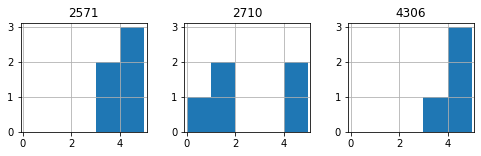

In [8]:
# create histograms for movie ratings
hist = utility_matrix.T.hist(bins=[0,1,2,3,4,5], layout=(1,5), figsize=(14,2));

# set axes
for ax in hist[0]:
    ax.set_ylim(0, 3.1)
    ax.set_xlim(-0.1, 5.1)

### Checkpoint - Pivot functie pandas
Vanaf dit punt zullen we gebruik maken van de ingebouwde pivot functie van pandas. Deze is geschreven in C en hoogstwaarschijnlijk dus sneller dan alles wat je zelf zou kunnen bedenken. Dit betekent ook dat, mocht bovenstaande niet gelukt zijn, je nu toch verder kunt werken aan de opdracht.

### Vraag 3 

Gegeven de bovenstaande histogrammen wat is de _naam_ van de film met de gemiddelde hoogste rating? 
En wat is de _naam_ van de film waarover de meningen het meest verdeeld zijn?

The matrix, The Blair Witch project

De histogrammen geven nog niet zo heel veel informatie over de films. Door scatterplots te gebruiken kunnen we de data inzichtelijker maken.

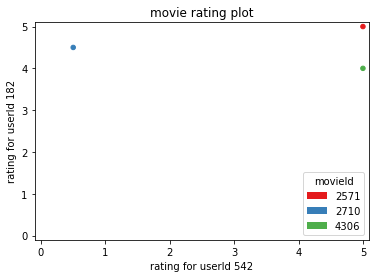

In [9]:
def plot_scatter(matrix, feature1, feature2, colors = ['#e41a1c', '#377eb8', '#4eae4b', '#994fa1', '#ff8101']):
    # setup plot
    elements = matrix.shape[0]
    scatter = matrix.plot.scatter(feature1, feature2, color = colors[:elements])
    scatter.set_title('movie rating plot')
    
    # plot settings
    scatter.set_xlim(-0.1, 5.1)
    scatter.set_ylim(-0.1, 5.1)
    scatter.set_xlabel('rating for userId {}'.format(feature1))
    scatter.set_ylabel('rating for userId {}'.format(feature2))
    scatter.legend([mpatches.Circle((0,0), 1, fc=c) for c in colors], matrix.index, loc = 'lower right', title = 'movieId')
    
# scatter plot    
plot_scatter(utility_matrix, 542, 182)

In de bovenstaande plot staan de punten voor de drie films. De x-as geeft de rating van Nocolai (542) en de y-as geeft de rating Gotlob (182). We kunnen ons dus de films als punten in een abstracte ruimte voorstellen. Zo'n ruimte wordt een **feature space** genoemt.

### Vraag 4

Als je naar deze ruimte kijkt, welke films denk je dan dat het meest op elkaar lijken? Waarom?

Shrek en The Matrix, de afstand tussen Shrek en The Matrix is het kleinst.

### Vraag 5

Plot de feature space zoals boven, maar dan voor Isaac en Gotlob.

Tip: Als je even snel wil kijken welke userId overeenkomt met welke naam kan je het commando `display(users)` gebruiken.

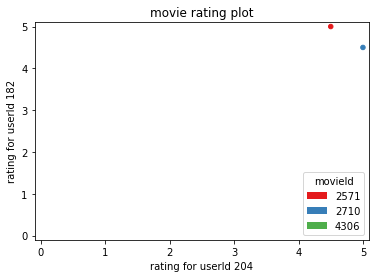

In [10]:
def plot_scatter(matrix, feature1, feature2, colors = ['#e41a1c', '#377eb8', '#4eae4b', '#994fa1', '#ff8101']):
    # setup plot
    elements = matrix.shape[0]
    scatter = matrix.plot.scatter(feature1, feature2, color = colors[:elements])
    scatter.set_title('movie rating plot')
    
    # plot settings
    scatter.set_xlim(-0.1, 5.1)
    scatter.set_ylim(-0.1, 5.1)
    scatter.set_xlabel('rating for userId {}'.format(feature1))
    scatter.set_ylabel('rating for userId {}'.format(feature2))
    scatter.legend([mpatches.Circle((0,0), 1, fc=c) for c in colors], matrix.index, loc = 'lower right', title = 'movieId')
    
# scatter plot    
plot_scatter(utility_matrix, 204, 182)


### Vraag 6

Als je naar _deze_ ruimte kijkt, welke films denk je _dan_ dat het meest op elkaar lijken?

The Matrix en The Blair Witch Project

Door de ratings voor te stellen als een ruimte (een feature space) kan je kijken of twee films fysiek dicht bij elkaar zitten. En dat kan wat zeggen over of de films wellicht op elkaar lijken. Met andere woorden, als veel gebruikers die The Matrix goed vonden ook een positieve beoordeling gegeven aan The Blair Witch Project, dan lijken die films wellicht op elkaar. Een recommender system kan dan kiezen om iemand die The Matrix goed vond ook The Blair Witch Project aan te bevelen.

In de bovenstaande voorbeelden gebruikten we steeds een 2D-ruimte, een gebruiker per as. Zoals je zag kan de uitkomst flink verschillen per ruimte. Normaal gesproken gebruik je geen 2D-feature space, maar is het aantal dimensies gelijk aan het aantal features in de tabel. In ons voorbeeld zijn dat vijf dimensies (namelijk de ranking van de vijf gebruikers, Ada, Nicolai, Isaac, Gotlob en Carl). 

Helaas is een hoog-dimensionale feature space lastig te plotten. Met een beetje moeite kan je nog 3 dimensies plotten:

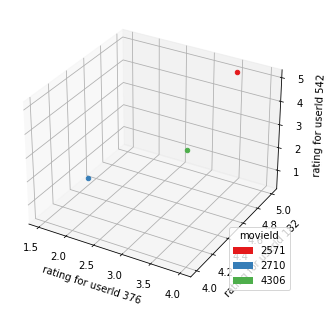

,movieId
userId,
195,Ada
542,Nicolai
204,Isaac
182,Gotlob
376,Carl


In [11]:
def plot3d(matrix, feature1, feature2, feature3, colors = ['#e41a1c', '#377eb8', '#4eae4b', '#994fa1', '#ff8101']):  
    # setup 3d plot
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    
    # enter data
    for i, ind in enumerate(matrix.index):
        scatter = ax.scatter(matrix.loc[ind, feature1], matrix.loc[ind, feature2], matrix.loc[ind, feature3], c = colors[i])

    # plot settings
    ax.legend([mpatches.Circle((0,0), 1, fc=c) for c in colors], matrix.index, loc = 'lower right', title = 'movieId')
    ax.set_xlabel('rating for userId {}'.format(feature1))
    ax.set_ylabel('rating for userId {}'.format(feature2))
    ax.set_zlabel('rating for userId {}'.format(feature3))
    
    plt.show()

plot3d(utility_matrix, 376, 182, 542)
display(users)

Helaas is zo'n 3D-plot lastig te lezen. Hoe ver liggen de films nou uit elkaar in de bovenstaande plot? Bovendien, we hebben nog meer dimensies die we willen laten zien. Een gebruikelijke manier om zo'n hoger dimensionale ruimte te plotten is een _scatter plot matrix_. Hierin maken we alle scatterplots van alle combinaties van dimensies. Dit werkt al een stuk beter:

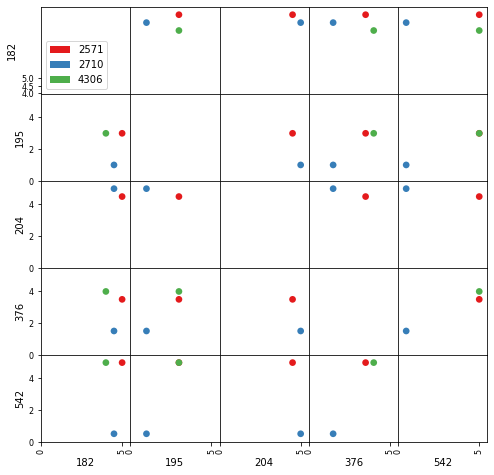

In [12]:
def plot_scatter_matrix(matrix, colors = ['#e41a1c', '#377eb8', '#4eae4b', '#994fa1', '#ff8101', '#000000', '#999999'], figsize = (8,8)):
    # setup plot
    max_val = matrix.max(axis = 1).max()
    min_val = matrix.min(axis = 1).min()
    fmatrix = matrix.fillna(min_val - 1)
    elements = fmatrix.shape[0]
    axarr = pd.plotting.scatter_matrix(fmatrix, s = 180.0, c = colors[:elements], figsize=figsize, alpha = 1.0, diagonal = '')
    m = fmatrix.shape[1]
    max_val = matrix.max(axis = 1).max()
    min_val = matrix.min(axis = 1).min()
    
    # set axes for all subplots
    for i in range(m):
        for j in range(m):
            axarr[i,j].set_xlim(min_val - 0.5, max_val + 0.5)
            axarr[i,j].set_ylim(min_val - 0.5, max_val + 0.5)

    # set labels for subplots
    labels = fmatrix.index 
    axarr[0,0].legend([mpatches.Circle((0,0),1,fc=c) for c in colors], labels, loc = 'lower left');

plot_scatter_matrix(utility_matrix)

### Vraag 7

a) Als je naar de bovenstaande scatterplot matrix kijkt, welke twee films denk je dat het meest op elkaar lijken? Beargumenteer.

b) Waarom zijn er geen plots getekend op de diagonaal?

c) Waarom bevatten sommige plots 3 punten en andere 2?

A) The Matrix en Shrek, voor bijna all punten is de afstand tussen Shrek en Matrix het kleinst in vergelijking tot The Blair witch Project

B) Er is geen plot getekend op de diagonaal, omdat ze anders tegen elkaar zouden plotten.

C) Sommige mensen hebben niet alle films gezien.

### Similarity

In het vorige deel hebben we gekeken of we aan de hand van de plots van de data konden zien welke films het meest op elkaar lijken. Nu gaan we kijken of we die intuïties iets verder kunnen formaliseren. 

Uiteindelijk willen we een functie maken die, aan de hand van de gegeven data, kan uitrekenen in welke mate twee films op elkaar lijken.

Eerst moeten we een goede definitie van afstand hebben. De eenvoudigste manier is door te kijken naar de verschillen in de ratings van de gebruikers.

<table><thead><tr style="text-align: center;"><th></th><th>2571</th><th></th><th>2710</th><th></th><th>difference</th><th></th></tr></thead>
<tbody><tr><th>182</th><td>5.0</td><td>-</td><td>4.5</td><td>=</td><td>0.5</td><td>(Gotlob vindt The Matrix beter dan The Blair Witch Project)</td></tr>
<tr><th>195</th><td>3.0</td><td>-</td><td>1.0</td><td>=</td><td>2.0</td><td>(Ada vindt beide films even goed)</td></tr>
<tr><th>204</th><td>4.5</td><td>-</td><td>5.0</td><td>=</td><td>-0.5</td><td>(Isaac vindt The Matrix een klein beetje slechter)</td></tr>
<tr><th>376</th><td>3.5</td><td>-</td><td>1.5</td><td>=</td><td>2.0</td><td>(Carl vindt The Blair Witch Project een stuk slechter)</td></tr>
<tr><th>542</th><td>5.0</td><td>-</td><td>0.5</td><td>=</td><td>4.5</td><td>(Nicolai vindt The Blair Witch Project heel veel slechter dan The Matrix)</td></tr>
</tbody></table>

Vervolgens berekenen we de afstand tussen de twee films door de som van de absolute waarde van deze verschillen te nemen:

$$
d = {\rm abs}(0.5) + {\rm abs}(2.0) + {\rm abs}(-0.5) + {\rm abs}(2.0) + {\rm abs}(4.5) = 10.5
$$

Deze afstandsmaat noemen we de **manhattan distance** (kijk [hier](https://en.wikipedia.org/wiki/Taxicab_geometry) als je wil weten waarom dit zo heet). Let wel, dit is een afstandsmaat: de waarde wordt _groter_ naarmate de films _minder_ op elkaar lijken. In de praktijk willen we een gelijkheidsmaat: een waarde die groter wordt naarmate de films _meer_ op elkaar lijken. Een afstandsmaat is vrij eenvoudig om te zetten naar een gelijkheidsmaat. Er zijn meerdere manieren waarop dit kan, maar een veelgebruikte functie is:

$$
s = 1/(1 + d)
$$

Waarbij $s$ staat voor _similarity_ en $d$ voor de _distance_. In het geval van dit voorbeeld is de similarity dus:

$$
1 / (1 + 10.5) = 0.087
$$

Voor de volledigheid geven we ook de formele definitie van de manhattan distance. Gegeven item (film) $x$ en item $y$ met $n$ features (user ratings) definiëren we de manhattan distance $d(x, y)$ als volgt:

$$
d(x, y) = \Sigma_{i=1}^{n}|x_{i} - y_{i}|
$$ 

$$
s(x, y) = 1/(1 + d(x, y))
$$


Hier volgt de implementatie van de manhattan distance:

### Missing values

Laten we kijken wat er gebeurt als we Shrek met The Matrix gaan vergelijken:


<table><thead><tr style="text-align: center;"><th></th><th>2571</th><th></th><th>4306</th><th></th><th>difference</th><th></th></tr></thead>
<tbody><tr><th>182</th><td>5.0</td><td>-</td><td>4.0</td><td>=</td><td>1.0</td><td>(Gotlob vindt The Matrix beter dan Shrek)</td></tr>
<tr><th>195</th><td>3.0</td><td>-</td><td>3.0</td><td>=</td><td>0.0</td><td>(Ada vindt beide films even goed)</td></tr>
    <tr><th>204</th><td>4.5</td><td>-</td><td><b>NaN</b></td><td>=</td><td><b>NaN</b></td><td>???</td></tr>
<tr><th>376</th><td>3.5</td><td>-</td><td>4.0</td><td>=</td><td>-0.5</td><td>(Carl vindt Shrek een klein beetje beter)</td></tr>
<tr><th>542</th><td>5.0</td><td>-</td><td>5.0</td><td>=</td><td>0.0</td><td>(Nicolai vindt beide films even goed)</td></tr>
</tbody></table>


$$
d = {\rm abs}(1.0) + {\rm abs}(0.0) + {\rm abs}({\bf NaN}) + {\rm abs}(-0.5) + {\rm abs}(0.0) = {\bf NaN}
$$

$$
s = 1/(1 + d) = 1/(1 + {\bf NaN}) = {\bf NaN}
$$

...

Omdat Shrek een NaN-waarde bevat komt er overal NaN uit. Dit is een probleem. Dit betekent dat we niet kunnen bepalen wat de similarity tussen The Matrix en Shrek is. Dat, terwijl er maar één waarde mist. Dus, als we in de dataset een film hebben die één gebruiker niet heeft gezien, kunnen we daar al geen similarity voor bepalen. Als je naar grotere datasets gaat kijken wordt dit probleem groter: er is altijd wel iemand die een bepaalde film niet gezien heeft.

De oplossing is om vóór je de similiarity gaat bepalen, hier iets voor in te vullen. Je zou bijvoorbeeld alle NaN's voor $0$ kunnen vervangen. Dit is eenvoudig, maar niet heel handig. Dan neem je eigenlijk aan dat als iemand de film niet gezien heeft, dat deze persoon de film waardeloos vindt. Dat is waarschijnlijk geen terechte aanname.

Een betere oplossing is de gemiddelde rating voor de film te berekenen en die in te vullen voor alle NaN waardes. Voor bijvoorbeeld Shrek nemen we het gemiddelde van alle waardes die we wel kennen: 

$$\frac{4.0 + 3.0 + 4.0 + 5.0}{4} = {\bf 4.0}$$

En die vullen we in voor de NaN waarde:

<table border="1" class="dataframe"><thead><tr style="text-align: right;"><th></th><th>182</th><th>195</th><th>204</th><th>376</th><th>542</th></tr></thead><tbody><tr><th>2571</th><td>5.0</td><td>3.0</td><td>4.5</td><td>3.5</td><td>5.0</td></tr><tr><th>2710</th><td>4.5</td><td>1.0</td><td>5.0</td><td>1.5</td><td>0.5</td></tr><tr><th>4306</th><td>4.0</td><td>3.0</td><td><b>4.0</b></td><td>4.0</td><td>5.0</td></tr></tbody></table>

De functie `fillna_mean()` hieronder vervangt de NaN waardes voor het gemiddelde van de betreffende rij.

In [13]:
def fill_nan_mean(matrix):
    # get the mean for each row
    meanv = matrix.mean(axis = 1, skipna=True)
    
    # fill all nan values with mean 
    # (fillna only works for collumns, so the matrix is transposed twice)
    filled1 = matrix.T.fillna(meanv).T
    
    # if there's still nan's left, it means the entire row is nan, so
    # no mean could be computed. fill with 0 in that case
    filled2 = filled1.fillna(0)
    return filled2
    
utility_matrix_filled = fill_nan_mean(utility_matrix)
display(utility_matrix_filled)

userId,182,195,204,376,542
movieId,,,,,
2571,5.0,3.0,4.5,3.5,5.0
2710,4.5,1.0,5.0,1.5,0.5
4306,4.0,3.0,4.0,4.0,5.0


In [14]:
def manhattan_distance(series1, series2):
    """ Compute manhattan distance between two datapoints. """     
    # compute the distances for the features
    distances = series1 - series2
    
    # return the absolute sum
    return distances.abs().sum()

def manhattan_similarity(matrix, id1, id2):
    """ Compute manhattan similarity between two datapoints. Can return a nan-value when there are no shared features. """
    # compute distance
    distance = manhattan_distance(matrix.loc[id1], matrix.loc[id2])
    
    # else return similarity
    return 1 / (1 + distance)

similarity = manhattan_similarity(utility_matrix, 2571, 4306)
print(f'Similarity between The Matrix and Shrek: {similarity:.2f}')

Similarity between The Matrix and Shrek: 0.40


Net als we eerder de utility matrix hadden gemaakt om gemakkelijk ratings op te kunnen zoeken, zo gaan we nu een matrix maken om makkelijk te kunnen zoeken naar similarity:

<table border="1" class="dataframe"><thead><tr style="text-align: right;"><th></th><th>2571</th><th>2710</th><th>4306</th></tr></thead><tbody><tr><th>2571</th><td>1.000000</td><td>0.095238</td><td>0.400000</td></tr><tr><th>2710</th><td>0.095238</td><td>1.000000</td><td>0.095238</td></tr><tr><th>4306</th><td>0.400000</td><td>0.095238</td><td>1.000000</td></tr></tbody></table>

### Vraag 8

De functie `create_similarity_matrix_manhattan()` hieronder is nog niet af. Er wordt al een matrix met de juiste dimensies gegenereerd, maar de rest is aan jou. Vul de matrix met de juiste similarities:

In [15]:
def create_similarity_matrix_manhattan(matrix):
    """ Creates the similarity matrix based on manhattan distance. """
    
    similarity_matrix = pd.DataFrame(data=0, index=matrix.index, columns=matrix.index, dtype=float)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
           similarity_matrix.iloc[i,j] = manhattan_similarity(matrix, similarity_matrix.columns[i] , similarity_matrix.columns[j])
        
    
    print(similarity_matrix)
    # TODO
    
    
    return similarity_matrix
           
similarity_matrix_manhattan = create_similarity_matrix_manhattan(utility_matrix)
display(similarity_matrix_manhattan)

movieId      2571      2710      4306
movieId                              
2571     1.000000  0.095238  0.400000
2710     0.095238  1.000000  0.095238
4306     0.400000  0.095238  1.000000


movieId,2571,2710,4306
movieId,,,
2571,1.000000,0.095238,0.400000
2710,0.095238,1.000000,0.095238
4306,0.400000,0.095238,1.000000


### Check

In [16]:
answers.test_8(create_similarity_matrix_manhattan, utility_matrix)

Check output type: movieId      2571      2710      4306
movieId                              
2571     1.000000  0.095238  0.400000
2710     0.095238  1.000000  0.095238
4306     0.400000  0.095238  1.000000
success!
Testing create_similarity_matrix_manhattan on complete data set: movieId      2571      2710      4306
movieId                              
2571     1.000000  0.095238  0.400000
2710     0.095238  1.000000  0.095238
4306     0.400000  0.095238  1.000000
success!
Testing create_similarity_matrix_manhattan on incomplete data set:           2571      2710  4306
2571  1.000000  0.153846   1.0
2710  0.153846  1.000000   1.0
4306  1.000000  1.000000   1.0
success!


Output second test:
          2571      2710  4306
2571  1.000000  0.153846   1.0
2710  0.153846  1.000000   1.0
4306  1.000000  1.000000   1.0


### Vraag 9

In de bovenstaande matrix bevatten alle cellen op de diagonaal de waarde 1.0. Waarom is dat?

Er is geen verschil in similarity tussen twee dezelfde films, daarom is de waarde altijd 1

### Euclidean similarity

Manhattan distance is een makkelijke maat om te gebruiken, maar wordt in de praktijk weinig gebruikt. Want stel, je hebt twee films met soortgelijke ratings, maar telkens met een klein verschil. Dan tel je bij de Manhattan distance alle verschillen in elke dimensie, hoe klein ze ook zijn, bij elkaar op. Daardoor lijkt het alsof de films toch veel verschillen.

Een populairdere maat is daarom de **Euclidische afstand**. Dit is de afstand die je krijgt als je de feature-space als een gewone fysieke ruimte beschouwd en de stelling van Pythagoras gebruikt om de afstand tussen twee punten (films) te bepalen. Door het gebruik van machten in de berekening van deze afstand worden kleine verschillen vrijwel genegeerd.

Net als bij de Manhattan distance kijken we eerst naar de verschillen in afstand.

<table><thead><tr style="text-align: center;"><th></th><th>2571</th><th></th><th>4306</th><th></th><th>difference</th><th></th></tr></thead>
<tbody><tr><th>182</th><td>5.0</td><td>-</td><td>4.0</td><td>=</td><td>1.0</td><td>(Gotlob vindt The Matrix beter dan Shrek)</td></tr>
<tr><th>195</th><td>3.0</td><td>-</td><td>3.0</td><td>=</td><td>0.0</td><td>(Ada vindt beide films even goed)</td></tr>
<tr><th>204</th><td>4.5</td><td>-</td><td>4.0</td><td>=</td><td>0.5</td><td>(Isaac vindt The Matrix een klein beetje beter)</td></tr>
<tr><th>376</th><td>3.5</td><td>-</td><td>4.0</td><td>=</td><td>-0.5</td><td>(Carl vindt Shrek een klein beetje beter)</td></tr>
<tr><th>542</th><td>5.0</td><td>-</td><td>5.0</td><td>=</td><td>0.0</td><td>(Nicolai vindt beide films even goed)</td></tr>
</tbody></table>

Vervolgens gebruiken we de stelling van Pythagoras voor het bereken van de euclidische afstand. In een 2D-ruimte is de stelling $d^2 = x^2 + y^2$ of, herschreven: $d = \sqrt{x^2 + y^2}$. In het 3D-geval is $d = \sqrt{x^2 + y^2 + z^2}$. In het algemeen is de stelling voor $n$ features $f_{1}$ t/m $f_{n}$:

$$
d = \sqrt{f_{1}^2 + f_{2}^2 + \ldots + f_{n}^2}
$$

In ons voorbeeld is de afstand $d$ dus:

$$
d = \sqrt{1.0^2 + 0.0^2 + 0.5^2 + -0.5^2 + 0.0^2} \approx 1.22
$$

Als we deze afstand omrekenen naar similarities:

$$
1 / (1 + 1.22) \approx 0.45
$$

De formele definitie:

$$
d(x, y) = \sqrt{\Sigma_{i=1}^{n}(x_{i} - y_{i})^2}
$$

$$
s(x, y) = 1/(1 + d(x, y))
$$

### Vraag 10

Implementeer hieronder de functie `create_similarity_matrix_euclid()`:

In [17]:
# TODO
def euclid_distance(series1, series2):
    """ Compute manhattan distance between two datapoints. """     
    # compute the distances for the features
    distances = (series1 - series2)**2
    
    # return the absolute sum
    return np.sqrt(distances.sum())

def euclid_similarity(matrix, id1, id2):
    """ Compute manhattan similarity between two datapoints. Can return a nan-value when there are no shared features. """
    # compute distance
    distance = euclid_distance(matrix.loc[id1], matrix.loc[id2])
    
    # else return similarity
    return 1 / (1 + distance)


def create_similarity_matrix_euclidean(matrix):
    """ Creates the similarity matrix based on eucledian distance. """
    
    """ Creates the similarity matrix based on manhattan distance. """
    
    similarity_matrix = pd.DataFrame(data=0, index=matrix.index, columns=matrix.index, dtype=float)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
           similarity_matrix.iloc[i,j] = euclid_similarity(matrix, similarity_matrix.columns[i] , similarity_matrix.columns[j])
        
    
    print(similarity_matrix)
    # TODO
    
    
    return similarity_matrix

similarity_matrix_euclidean = create_similarity_matrix_euclidean(utility_matrix_filled)
display(similarity_matrix_euclidean)

movieId      2571      2710      4306
movieId                              
2571     1.000000  0.157186  0.449490
2710     0.157186  1.000000  0.150722
4306     0.449490  0.150722  1.000000


movieId,2571,2710,4306
movieId,,,
2571,1.000000,0.157186,0.449490
2710,0.157186,1.000000,0.150722
4306,0.449490,0.150722,1.000000


### Check

In [18]:
answers.test_10(create_similarity_matrix_euclidean, utility_matrix)

Check output type: movieId      2571      2710      4306
movieId                              
2571     1.000000  0.157186  0.472136
2710     0.157186  1.000000  0.152782
4306     0.472136  0.152782  1.000000
success!
Testing create_similarity_matrix_euclid on complete data set: movieId      2571      2710      4306
movieId                              
2571     1.000000  0.157186  0.472136
2710     0.157186  1.000000  0.152782
4306     0.472136  0.152782  1.000000
success!
Testing create_similarity_matrix_euclid on incomplete data set:           2571      2710  4306
2571  1.000000  0.180011   1.0
2710  0.180011  1.000000   1.0
4306  1.000000  1.000000   1.0
success!


### Cosine similarity

Voor het vergelijken van verschillende items wordt in de praktijk veel van de _cosine similarity_ gebruik gemaakt. Voor het bepalen hiervan trekken we twee denkbeeldige lijnen van de oorsprong naar de data punten die we willen vergelijken en nemen we de hoek tussen die twee lijnen: 

<img src = './include/cosine similarity.png'>

In het bovenstaande voorbeeld bepalen we de cosine similarity voor film 2571 en 2710 en kijken we even alleen naar de ratings van gebruiker 195 en 542. De hoek tussen de twee lijnen voor beide films $\Theta$ is $0.57^{\circ}$ rad. De cosine similarity is gedefinieerd als de cosinus van deze hoek. In dit voorbeeld is de similarity dus cos$(0.57) \approx 0.84$.

In het geval van de cosine similarity doet de afstand van een punt tot oorsprong er niet toe. Waarom zou dit een voordeel kunnen zijn?

Het bereken van de cosine similarity is eenvoudiger dan het voorbeeld doet vermoeden voor twee punten $A = (a_1, a_2)$ en $B = (b_1, b_2)$ is de cosine similarity:
$$
\textrm{cos}(A, B) = \frac{a_1*b_1 + a_2*b_2}{\sqrt{a_1^2 + a_2^2}*\sqrt{b_1^2 + b_2^2}}
$$

In ons geval is dat dus:
$$
\textrm{cos}(2571, 2710) = \frac{3.0*1.0 + 5.0*0.5}{\sqrt{3.0^2 + 5.0^2} * \sqrt{1.0^2 + 0.5^2}} \approx 0.84
$$

In de bovenstaande berekening hebben we voor het gemak aangenomen dat er maar twee features zijn (de ratings van gebruiker 195 en 542). In werkelijkheid hebben we natuurlijk niet twee features, maar veel meer. In ons geval hebben we er vijf. De algemene formule voor de cosinus van items met $n$ features $A = (a_1, a_2, \ldots, a_n)$ en $B = (b_1, b_2, \ldots, b_n)$ is:

$$
\textrm{cos}(A, B) = \frac{a_1*b_1 + a_2*b_2 + \ldots + a_n*b_n}{\sqrt{a_1^2 + a_2^2 + \ldots + a_n^2}*\sqrt{b_1^2 + b_2^2 + \ldots b_n^2}}
$$

In ons geval is dat dus:
$$
\textrm{cos}(2571, 2710) = \frac{5.0*4.5  + 3.0*1.0 + 4.5*5.0 + 3.5*1.5 + 5.0*0.5}{\sqrt{5.0^2 + 3.0^2 + 4.5^2 + 3.5^2 + 5.0^2} * \sqrt{4.5 ^ 2  + 1.0^2 + 5.0^2 + 1.5^2 + 0.5^2}} \approx 0.83
$$

De formele definitie:
$$
\textrm{cos}(A, B) = \frac{\sum_{i = 1}^n a_i * b_i}{\sqrt{\sum_{i = 1}^n a_i^2}{\sqrt{\sum_{i = 1}^n b_i^2}}}
$$

### Vraag 11

Gebruik de bovenstaande formule voor het implementeren van de functie `create_similarity_matrix_cosine_temp()` hieronder. Er is een belangrijk randgeval waar je rekening mee moet houden:
- Als een rij alleen maar `0`-en bevat (alle ratings voor een film waren `0`), er een deling door nul kan plaatsvinden. Detecteer waar dit gebeurt, en vang het af door hier een nul te plaatsen in de nieuwe similarity matrix.

In [19]:
# TODO
# TODO
from scipy.special import logsumexp
def cosine_temp_distance(series1, series2):
    """ Compute manhattan distance between two datapoints. """     
    # compute the distances for the features
    distances = series1 * series2
    a1 = series1**2
    b1 = series2**2
    
    # return the absolute sum
    return distances.sum()/(np.sqrt(a1.sum())*np.sqrt(b1.sum()))

def cosine_temp_similarity(matrix, id1, id2):
    """ Compute manhattan similarity between two datapoints. Can return a nan-value when there are no shared features. """
    # compute distance
    matrix = matrix.replace(np.nan,0.0)
    distance = cosine_temp_distance(matrix.loc[id1], matrix.loc[id2])

    # else return similarity
    return distance


def create_similarity_matrix_cosine_temp(matrix):
    
    
    similarity_matrix = pd.DataFrame(data=0, index=matrix.index, columns=matrix.index, dtype=float)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
           similarity_matrix.iloc[i,j] = cosine_temp_similarity(matrix, similarity_matrix.columns[i] , similarity_matrix.columns[j])
        

    # TODO
    
    
    return similarity_matrix


similarity_matrix_cosine = create_similarity_matrix_cosine_temp(utility_matrix_filled)
display(similarity_matrix_cosine)

u3tility_matrix = DataFrame(
        [[5.0, np.nan, 4.5, np.nan, 5.0], [4.5, np.nan, 5.0, 1.5, 0.5],
         [np.nan, 3.0, np.nan, np.nan, np.nan]], columns=[182, 195, 204, 376, 542],
        index=[2571, 2710, 4306])
similarity_matrix_cosine = create_similarity_matrix_cosine_temp(u3tility_matrix)
display(similarity_matrix_cosine)


movieId,2571,2710,4306
movieId,,,
2571,1.000000,0.834732,0.992844
2710,0.834732,1.000000,0.782908
4306,0.992844,0.782908,1.000000


,2571,2710,4306
2571,1.000000,0.820132,0.0
2710,0.820132,1.000000,0.0
4306,0.000000,0.000000,1.0


### Check

In [20]:
answers.test_11(create_similarity_matrix_cosine_temp, utility_matrix)

Check output type: success!
Testing create_similarity_matrix_cosine on complete data set: success!
Testing create_similarity_matrix_cosine on incomplete data set: success!
Testing create_similarity_matrix_cosine on a dataset with a movie that has only been rated with 0: 

FloatingPointError: invalid value encountered in double_scalars

### Checkpoint - Cosine Similarity from sklearn
Voor de geïmplementeerde cosinus functie geldt hetzelfde als voor de pivot functie. We kunnen deze beter vervangen door een functie uit een library. Hieronder wordt gedemonstreerd hoe je gebruik kunt maken van de cosine_similarity functie uit de `sklearn` library.

Dit betekent ook dat je vanaf hier verder kunt werken mocht het implementeren van deze functie niet gelukt zijn.

In [21]:
from sklearn.metrics.pairwise import cosine_similarity as cosine_similarity_sklearn

def create_similarity_matrix_cosine(utility_matrix):
    """ Creates similarity matrix from the utility matrix. The function from sklearn
        does not take NaN values so we temporarily fill them with the mean rating
        from a movie. """    
    # sklearn needs a numpy ndarray as input, so convert the matrix
    matrix = np.array(utility_matrix)
    
    similarities = cosine_similarity_sklearn(matrix)
    
    # convert the output back to a pandas dataframe
    similarity_matrix = pd.DataFrame(data=similarities[0:,0:],
                                    index=utility_matrix.index,
                                    columns=utility_matrix.index)

    return similarity_matrix

similarity_matrix_cosine = create_similarity_matrix_cosine(utility_matrix_filled)
display(similarity_matrix_cosine)

movieId,2571,2710,4306
movieId,,,
2571,1.000000,0.834732,0.992844
2710,0.834732,1.000000,0.782908
4306,0.992844,0.782908,1.000000


#### Intermezzo - Verschil in computation time
We kunnen natuurlijk wel zeggen dat een functie uit een library sneller is, maar het is goed om dat even te testen. Hieronder wordt dit gedaan, gebruikmakend van een van de `cellmagic` [commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html) in jupyter notebook: `%%timeit`.

In [22]:
%%timeit -r 10
similarity_matrix_cosine = create_similarity_matrix_cosine_temp(utility_matrix_filled)

3.22 ms ± 90.2 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [23]:
%%timeit -r 10
similarity_matrix_cosine = create_similarity_matrix_cosine(utility_matrix_filled)

73.6 µs ± 1.91 µs per loop (mean ± std. dev. of 10 runs, 10,000 loops each)


### Mean centering

Het probleem met de cosine similarity is dat het erg gevoelig is voor bias. Dat wil in dit geval zeggen, als de gemiddelde waarde van een feature geen 0 is, dan geeft de cosine similarity geen goede scores. In ons geval is dit een probleem. De gemiddelde rating per gebruiker is zeker geen 0.

De oplossing hiervoor is **mean centering**. Hierbij is het idee om elke rating van een gebruiker te verminderen met de gemiddelde rating _van diezelfde_ gebruiker. Aangezien we in de utility matrix elke kolom de ratings van één gebruiker staan komt het er dus op neer elke kolom te verminderen met het gemiddelde van die kolom.

Hieronder zie je het effect hiervan. In Figuur 1 zien we de cosine similarity zonder mean centering, in Figuur 2 de cosine similairty van dezelfde twee punten, maar met centering. De cosine similarity toegepast op een mean centered utility matrix wordt ook wel de **adjusted cosine** genoemd. 

<table>
    <tr style ="background-color: #ffffff"><td style="text-align:center">Figuur 1</td><td style="text-align:center">Figuur 2</td></tr>
    <tr><td><img src = './include/cosine similarity.png'></td><td><img src = './include/adjusted cosine similarity.png'></td></tr>
</table>

### Vraag 12

Implementeer hieronder de functie `mean_center_columns()`:

In [24]:
def mean_center_columns(matrix):
    
    meanmatrix = matrix.mean(axis = 0)
    meanmatrix = np.array(meanmatrix)
    print(meanmatrix)
    for i in range(len(matrix)):
        for j in range(len(matrix.columns)):
             matrix.iloc[i,j]=  matrix.iloc[i,j] - meanmatrix[j]
    
    return matrix
    # TODO
    
    
centered_utility_matrix = mean_center_columns(utility_matrix_filled)
similarity = create_similarity_matrix_cosine(centered_utility_matrix)

print("The original utility matrix:")    
display(utility_matrix)

print("The matrix with filled NaN values:")
display(utility_matrix_filled)

print("The filled matrix mean centered:")
display(centered_utility_matrix)

print("The similarity matrix based on the mean centered utility matrix:")
display(similarity)

[4.5        2.33333333 4.5        3.         3.5       ]
The original utility matrix:


userId,182,195,204,376,542
movieId,,,,,
2571,5.0,3.0,4.5,3.5,5.0
2710,4.5,1.0,5.0,1.5,0.5
4306,4.0,3.0,NaN,4.0,5.0


The matrix with filled NaN values:


userId,182,195,204,376,542
movieId,,,,,
2571,0.5,0.666667,0.0,0.5,1.5
2710,0.0,-1.333333,0.5,-1.5,-3.0
4306,-0.5,0.666667,-0.5,1.0,1.5


The filled matrix mean centered:


userId,182,195,204,376,542
movieId,,,,,
2571,0.5,0.666667,0.0,0.5,1.5
2710,0.0,-1.333333,0.5,-1.5,-3.0
4306,-0.5,0.666667,-0.5,1.0,1.5


The similarity matrix based on the mean centered utility matrix:


movieId,2571,2710,4306
movieId,,,
2571,1.000000,-0.942604,0.804393
2710,-0.942604,1.000000,-0.956601
4306,0.804393,-0.956601,1.000000


### Check

In [25]:
answers.test_12(mean_center_columns, utility_matrix_filled, create_similarity_matrix_cosine)

Check output type: [ 0.00000000e+00 -1.48029737e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
success!
Testing mean_center_columns on complete data set: [0. 0. 0. 0. 0.]
success!
Testing create_similarity_matrix_cosine on complete data set: success!
Testing mean_center_columns on incomplete data set: [4.75 3.   4.75 1.5  2.75]
success!


### Voorspellingen (K-nearest neighbor)

We hebben nu meerdere maten voor het vergelijken van films. Hoe kunnen we de similarity functies gebruiken voor het aanbevelen van films. Dit probleem kunnen we herformuleren: Gegeven een gebruiker (de *target user*) die een bepaalde film (de *target film*) nog niet heeft gezien, hoe zou deze gebruiker de film raten na het zien?

De kern van het probleem is dus het voorspellen van een "missende" rating.

Er zijn veel mogelijke aanpakken, maar een veelgebruikte manier voor het aanbevelen van items is **K-nearest neighbor (KNN) regression**. Dat is een hele mondvol, maar de intuïtie is eenvoudig: We spreken een getal _K_ af (bijvoorbeeld 5). Vervolgens, voor de *target film*, kijken we welke _K_ (5) films er het meeste op lijken. Dit is de *neighborhood*. Tot slot kijk je wat de *target user* gemiddeld vond van de films in de neigborhood. 

Het algoritme bestaat dus uit twee stappen:

1. Selecteer de *neighborhood* van de *target film*. Selecteer alle films waarvoor geldt dat:
    - de *target user* de film gezien heeft
    - de film zeer vergelijkbaar is met de *target film*
    
    
2. Neem het gewogen gemiddelde van de geselecteerde films. Dat wil zeggen dat een film die meer vergelijkbaar is met de *target film* ook meer bijdraagt aan het gemiddelde.

Om deze stappen uit te werken hebben we iets meer data nodig. Voor het uitproberen van het algoritme voegen we handmatig wat data toe. We introduceren 2 extra gebruikers (123 en 456) en een extra film (4444):

In [26]:
# create some mock data
l = [[123, 2571, 5.0, 0], [123, 2710, 1.5, 0], [123, 4444, 4.0, 0], [456, 2571, 1.5, 0], 
     [456, 2710, 5.0, 0], [456, 4444, 1.0, 0], [182, 4444, 3.0, 0], [195, 4444, 2.0, 0], 
     [204, 4444, 4.0, 0], [376, 4444, 4.5, 0], [542, 4444, 4.5, 0], [123, 5555, 3.5, 0], 
     [456, 5555, 3.5, 0]]
extra_data = pd.DataFrame(data=l, columns = ratings.columns)
more_ratings = pd.concat([ratings, extra_data]).reset_index(drop=True)

display(more_ratings)

# recompute utility matrix
utility_matrix2 = pivot_ratings(more_ratings)
display(utility_matrix2)

utility_matrix2_filled = fill_nan_mean(utility_matrix2)

# recompute similarity matrix
centered_matrix = mean_center_columns(utility_matrix2_filled)
similarity = create_similarity_matrix_cosine(centered_matrix)
display(similarity)

,userId,movieId,rating,timestamp
0,182,2571,5.0,1054779786
1,182,2710,4.5,1063284735
2,182,4306,4.0,1054780155
3,195,2571,3.0,974705726
4,195,2710,1.0,974706758
5,195,4306,3.0,994032742
6,204,2571,4.5,1327183462
7,204,2710,5.0,1327185697
8,376,2571,3.5,1364994024
9,376,2710,1.5,1364994544


userId,123,182,195,204,376,456,542
movieId,,,,,,,
2571,5.0,5.0,3.0,4.5,3.5,1.5,5.0
2710,1.5,4.5,1.0,5.0,1.5,5.0,0.5
4306,NaN,4.0,3.0,NaN,4.0,NaN,5.0
4444,4.0,3.0,2.0,4.0,4.5,1.0,4.5
5555,3.5,NaN,NaN,NaN,NaN,3.5,NaN


[3.6 4.  2.5 4.2 3.4 3.  3.7]


movieId,2571,2710,4306,4444,5555
movieId,,,,,
2571,1.000000,-0.759017,0.198517,0.467357,-0.350177
2710,-0.759017,1.000000,-0.535600,-0.690319,-0.090078
4306,0.198517,-0.535600,1.000000,-0.069242,0.335994
4444,0.467357,-0.690319,-0.069242,1.000000,-0.245576
5555,-0.350177,-0.090078,0.335994,-0.245576,1.000000


Zoals je ziet in de utility matrix hebben de nieuwe gebruikers (123 en 456) geen rating voor de film Shrek (4306). Deze hebben we voor het uitrekenen van de cosine similarity ingevuld met de gemiddelde beoordeling van de film, maar we gaan ze nu proberen op een betere manier te voorspellen.

Om een beeld te krijgen van deze nieuwe data maken we weer een plot:

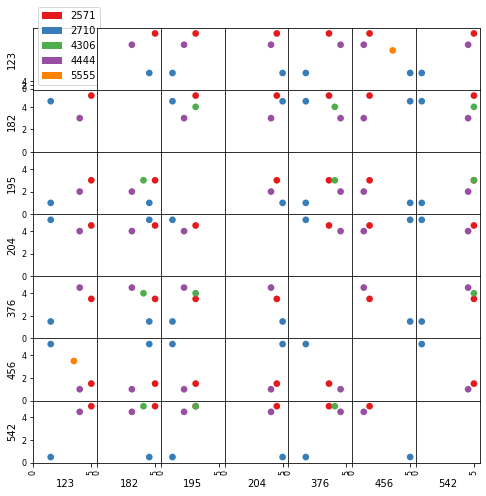

In [27]:
# to see the difference
# plot_scatter_matrix(utility_matrix2.T.fillna(utility_matrix2.mean(axis=1)).T)
plot_scatter_matrix(utility_matrix2)

### Vraag 13

Als je naar de bovenstaande plots kijkt, welke film zou je aanbevelen aan gebruiker 123? En aan gebruiker 456? Beargumenteer.

gebruiker 123 zal film Shrek aangeraden worden en gebruiker 456 The Matrix. Bij gebruiker 123 en 456 is gekeken naar andere gebruikers met soort gelijke film rating.

### Vraag 14

We gaan eerst Stap 1 van het algoritme uitwerken:

1. Selecteer de neighborhood van de target film. Selecteer alle films waarvoor geldt dat:
    - de target user de film gezien heeft
    - de film zeer vergelijkbaar is met de target film

We moeten alleen een definitie geven van "zeer vergelijkbaar". Hiervoor kunnen we vele keuzes maken. Vaak worden de top $k$ meest vergelijkbare items genomen. Waarbij de beste waarde voor $k$ proefondervindelijk wordt vastgesteld. Bovendien is het belangrijk om alleen items te nemen waarvan de _cosine similarity_ groter is dan 0.

Implementeer hieronder de functie `select_neighborhood()`. Deze functie krijgt als input een `Series` met de similarities, een `Series` met ratings en de parameter `k` en geeft een `Series` terug met de top `k` `movieId`'s en de bijbehorende similarities. Voor bijvoorbeeld gebruiker 123, film 4306 en k = 10 geeft de functie de volgende `Series` terug:

    movieId
    2571    0.198517
    5555    0.335994
    Name: 4306, dtype: float64
    
Let op: deze output bevat niet de films 2710, 4306. De films 2710 en 4444 missen omdat de similarity kleiner is dan 0, en 4306 mist omdat gebruiker 123 deze nog niet heeft gezien. De output bevat bovendien maar 2 items, in plaats van 10. Dit komt omdat er in totaal maar 2 films zijn die een similarity groter dan 0 hebben met film 4306.

> Tip: Als je naar de aanroep van de functie `select_neighborhood` kijkt, zie je dat we daar de `utility_matrix2` gebruiken en niet `utility_matrix2_filled`. Waarom is dat?

In [28]:
def select_neighborhood(similarities, ratings, k):
    """ selects the k items all items with similarity > 0  """
    
    # Filter out items with a similarity score of 0 or less
    rslt_df = similarities[similarities > 0]
    if len(rslt_df) == 1:
        return rslt_df
        
    elif(len(rslt_df) > 1):
        rslt_df = rslt_df[rslt_df<1]
        return rslt_df[:k,]
    
    elif(rslt_df.empty == True):
        return rslt_df
    

neighborhood = select_neighborhood(similarity[4306], utility_matrix2[123], 2)
display(neighborhood)

movieId
2571    0.198517
5555    0.335994
Name: 4306, dtype: float64

### Check

In [29]:
answers.test_14(select_neighborhood, similarity, utility_matrix2)

Check output type: success!
Check select_neighborhood for user 123: success!
Check select_neighborhood for user 456: success!
Check select_neighborhood for movie 2710 and user 195: success!
Check empty neighborhood: success!
Check only zero similarity: success!


/Users/padmadhuney/Documents/Informatiekunde/CI/Module 2/answers.py:295: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _solution = pd.Series([], index=[])
/Users/padmadhuney/Documents/Informatiekunde/CI/Module 2/answers.py:304: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _solution = pd.Series([], index=[])


### Vraag 15

Nu rest nog stap 2 van het algoritme:

2. Neem het gewogen gemiddelde van de geselecteerde films. Dat wil zeggen dat een film die meer vergelijkbaar is met de _target film_ ook meer bijdraagt aan het gemiddelde.

In het voorbeeld hierboven bevat de neighborhood de similarities $0.73$ en $0.58$ voor respectievelijk de films 2571 en 4444. De ratings die gebruiker 123 voor deze films heeft gegeven zijn $5.0$ en $4.0$. Het gewogen gemiddelde is dan:
$$
\textrm{predicted rating} = \frac{5.0 * 0.73+4.0 * 0.58}{0.73 + 0.58} \approx 4.56
$$

De formele definitie (met $r_i$ de rating en $s_i$ de similarity voor film $i$):
$$
\textrm{predicted rating} = \frac{\sum_{\textrm{i in neighborhood}} r_i * s_i}{\sum_{\textrm{i in neighborhood}}s_i}
$$

Implementeer hieronder de laatste stap van het item based collaborative filtering algoritme. Implementeer de functie `weighted_mean()`.

In [30]:
def weighted_mean(neighborhood, ratings):  
    k =  neighborhood*ratings
    ratingInNeighbourHood = (ratings/ratings) *neighborhood
    ratingInNeighbourHood = ratingInNeighbourHood.dropna() 
    k = k.dropna() 
    if k.empty == True:
        return np.nan
    
    else:
        return k.sum()/ratingInNeighbourHood.sum()
    
    # TODO
    
neighborhood1 = select_neighborhood(similarity[4306], utility_matrix2[123], 10)
neighborhood2 = select_neighborhood(similarity[4306], utility_matrix2[456], 10)
"""
print(neighborhood1)
print(neighborhood2)
print(utility_matrix2[123])
print(utility_matrix2[456])
"""
prediction1 = weighted_mean(neighborhood1, utility_matrix2[123])
prediction2 = weighted_mean(neighborhood2, utility_matrix2[456])

print(f'User 123 predicted rating for Shrek {prediction1:.2f}')
print(f'User 456 predicted rating for Shrek {prediction2:.2f}')  

User 123 predicted rating for Shrek 4.06
User 456 predicted rating for Shrek 2.76


### Check

In [31]:
answers.test_15(select_neighborhood, similarity, utility_matrix2, weighted_mean)

Check output type: success!
Testing predictions: success!
Testing prediction for empty neighborhood: success!


### Vraag 16

Conclusie: Zou je gebruiker 123 Shrek aanraden? En gebruiker 456?

Gebruiker 123 zou je Shrek wel aanraden want de prediction is 4.06, want dat ligt aan de hoge kant. Gerbuiker 456 zou je Shrek niet aanraden, omdat de prediction 2.76 is en dat is aan de lage kant.

# Deel 2: User based filtering

Tot nu toe keken we naar item based filtering. Hier voorspellen we ratings aan de hand van vergelijkbaarheid van de items (films). De voornaamste tegenhanger van item based filtering is *user based filtering*. Dit is het collaborative filtering equivalent van iemand met dezelfde filmsmaak om advies vragen. 

Het proces van user based filtering is vrijwel identiek aan item based filtering. We draaien alleen de rollen om:

- in plaats van een utility matrix met horizontaal de gebruikers en verticaal de films, wisselen we de assen om  
- in plaats van een similarity matrix voor films maken we een similarity matrix voor gebruikers
- in plaats van een neighborhood van de _target film_ selecteren we een neighborhood van de _target user_.
- in plaats van een gewogen gemiddelde van de ratings van vergelijkbare films nemen we een gewogen gemiddelde van de ratings van vergelijkbare users.

Voor de onderstaande vragen gaan we weer van de _uitgebreide ratings data_ uit.

Tip: Voor de onderstaande vragen hoef je maar weinig code te schrijven. **Maak zoveel mogelijk gebruik van de functies die je hierboven geschreven hebt.** Als je in een cel meer dan een paar regels code moet schrijven maak je het waarschijnlijk te ingewikkeld.

In [32]:
display(more_ratings)

,userId,movieId,rating,timestamp
0,182,2571,5.0,1054779786
1,182,2710,4.5,1063284735
2,182,4306,4.0,1054780155
3,195,2571,3.0,974705726
4,195,2710,1.0,974706758
5,195,4306,3.0,994032742
6,204,2571,4.5,1327183462
7,204,2710,5.0,1327185697
8,376,2571,3.5,1364994024
9,376,2710,1.5,1364994544


### Vraag 17

Maak een nieuwe utility matrix en sla deze op als `utility_matrix3`, maar nu met de gebruikers als rijen en de films als kolommen.

Maak ook een versie van `utility_matrix3` met ingevulde NaN waardes en noem deze `utility_matrix3_filled`. Let er op dat je hier de gemiddelde rating _van de film_ invult.

Tip: met `df.T` kan je de rijen en kolommen van dataframe `df` omwisselen.

In [33]:
# TODO
utility_matrix3 = utility_matrix2.T
utility_matrix3_filled = utility_matrix2_filled.T

display(utility_matrix3)

display(utility_matrix3_filled)

movieId,2571,2710,4306,4444,5555
userId,,,,,
123,5.0,1.5,NaN,4.0,3.5
182,5.0,4.5,4.0,3.0,NaN
195,3.0,1.0,3.0,2.0,NaN
204,4.5,5.0,NaN,4.0,NaN
376,3.5,1.5,4.0,4.5,NaN
456,1.5,5.0,NaN,1.0,3.5
542,5.0,0.5,5.0,4.5,NaN


movieId,2571,2710,4306,4444,5555
userId,,,,,
123,1.4,-2.1,0.4,0.4,-0.1
182,1.0,0.5,0.0,-1.0,-0.5
195,0.5,-1.5,0.5,-0.5,1.0
204,0.3,0.8,-0.2,-0.2,-0.7
376,0.1,-1.9,0.6,1.1,0.1
456,-1.5,2.0,1.0,-2.0,0.5
542,1.3,-3.2,1.3,0.8,-0.2


### Check

In [34]:
answers.test_17(utility_matrix3)

Check output type: success!
Check select_neighborhood for user 123: success!


### Vraag 18

Maak een scatter plot matrix van de utility matrix.

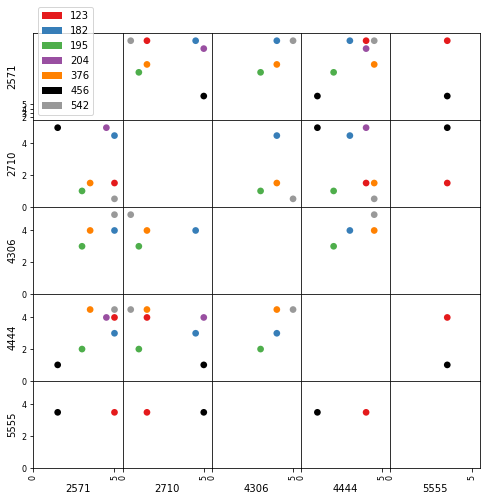

In [35]:
# TODO
plot_scatter_matrix(utility_matrix3)

### Vraag 19

Maak een mean centered utility matrix genaamd `centered_utility_matrix`. Let hierbij op: Dit is het enige waarbij de rollen niet zijn omgedraaid. We willen nog steeds de gemiddelde rating van de _gebruikers_ als offset gebruiken, niet die van de films. Het gaat er namelijk niet om hoe een gebruiker afwijkt van het gemiddelde rating van een film, maar wel hoe de gebruiker afwijkt van zijn gemiddelde rating bij een film. Met ander woorden, je moet hier de rijen centeren in plaats van de kolommen.

In [36]:

centered_utility_matrix = utility_matrix2_filled.T
display(centered_utility_matrix)

movieId,2571,2710,4306,4444,5555
userId,,,,,
123,1.4,-2.1,0.4,0.4,-0.1
182,1.0,0.5,0.0,-1.0,-0.5
195,0.5,-1.5,0.5,-0.5,1.0
204,0.3,0.8,-0.2,-0.2,-0.7
376,0.1,-1.9,0.6,1.1,0.1
456,-1.5,2.0,1.0,-2.0,0.5
542,1.3,-3.2,1.3,0.8,-0.2


### Check

In [37]:
answers.test_19(centered_utility_matrix)

Check output type: success!
Testing mean centered matrix on complete data set: success!


### Vraag 20

Bereken de adjusted cosine similarity matrix voor de gebruikers en sla deze op in een variabele genaamd `similarity`.

In [38]:
# TODO
similarity = create_similarity_matrix_cosine(centered_utility_matrix)


display(similarity)

userId,123,182,195,204,376,456,542
userId,,,,,,,
123,1.000000e+00,-1.908196e-17,0.724376,-0.457430,0.813209,-0.768984,0.960334
182,-1.908196e-17,1.000000e+00,-0.079057,0.693375,-0.554700,0.233126,-0.167248
195,7.243757e-01,-7.905694e-02,1.000000,-0.767426,0.602977,-0.258023,0.727218
204,-4.574300e-01,6.933752e-01,-0.767426,1.000000,-0.730769,0.258630,-0.568233
376,8.132090e-01,-5.547002e-01,0.602977,-0.730769,1.000000,-0.711233,0.910332
456,-7.689843e-01,2.331262e-01,-0.258023,0.258630,-0.711233,1.000000,-0.682325
542,9.603343e-01,-1.672484e-01,0.727218,-0.568233,0.910332,-0.682325,1.000000


### Check

In [ ]:
answers.test_20(similarity)

### Vraag 21

Bereken de neighborhood voor gebruiker 123 en 456 ten opzichte van film 4306. Sla de neighborhood van gebruiker 123 op in een variabele genaamd `neighborhood1` en voor gebruiker 456 in een variabele genaamd `neighborhood2`.

In [ ]:
# TODO

neighborhood1 = select_neighborhood(similarity[123], utility_matrix3[4306], 4)
neighborhood2 = select_neighborhood(similarity[456], utility_matrix3[4306],1)

print(neighborhood1) # print the neighborhood for user 123
print(neighborhood2) # print the neighborhood for user 456

### Check

In [ ]:
answers.test_21(neighborhood1, neighborhood2)

### Vraag 22

Bereken het gewogen gemiddelde voor de neighborhoods van user 123 en 456 (met de ratings voor film 4306).

In [ ]:
# TODO

prediction1 = weighted_mean(neighborhood1, utility_matrix3[4306])
prediction2 = weighted_mean(neighborhood2, utility_matrix3[4306])

print(f'User 123 predicted rating for Shrek {prediction1:.2f}')
print(f'User 456 predicted rating for Shrek {prediction2:.2f}') 

### Check

In [ ]:
answers.test_22(prediction1, prediction2)

### Vraag 23

Als je deze user based voorspelling vergelijkt met de item based voorspelling, welke lijkt je dan beter? Beargumenteer in een paar korte zinnen. (In het volgende deel gaan we kijken hoe je de kwaliteit van de aanpak kan evalueren.)   

item-based voorspelling. Bij item-based voorspelling richt zich op de overeenkomsten tussen items zelf. Ze bevelen items aan die vergelijkbaar zijn met items waarin de gebruiker al interesse hebben getoond. Deze aanpak werkt goed wanneer er veel items zijn en gebruikers verschillende voorkeuren hebben.

Welk algoritme is nou beter? Misschien dat je daar voor deze speicifieke data set zo op het oog een uitspraak over kan doen. Maar in het algemeen, hoe goed is een specifiek recommender system? Hoe definiëren we überhaupt "goed"? Hier gaan we in de volgende module naar kijken.